## 英文语料生成词云


- 张伦老师12月18日的授课内容是用 KNIME 构建一个词云生成工作流，我将工作流改为 Python 程序，KNIME 适合构建一个清晰的处理框架，可以先在 KNIME 把工作流构建出来，然后按照流的逻辑转化为相应代码


- 版本：Python 3.6


- By Lyndon, 2018-12-20

In [1]:
# 对应 File Reader
import pandas as pd

data = pd.read_csv('/Users/lyndon/knime-workspace/wordcloud/IMDb-sample.csv')
print(data.shape)
data.head()

(2000, 4)


,Index,URL,Text,Sentiment
0,3617,http://www.imdb.com/title/tt0210075/usercomments,Girlfight follows a project dwelling New York ...,POS
1,3671,http://www.imdb.com/title/tt0337640/usercomments,Hollywood North is an euphemism from the movie...,POS
2,3157,http://www.imdb.com/title/tt0303549/usercomments,That '70s Show is definitely the funniest show...,POS
3,660,http://www.imdb.com/title/tt0716825/usercomments,"9/10- 30 minutes of pure holiday terror. Okay,...",POS
4,265,http://www.imdb.com/title/tt0182225/usercomments,"A series of random, seemingly insignificant th...",POS


In [2]:
# Column Filter和 Strings To Document 并不需要，因为 Python 可以在不改变数据类型的前提下专门选择某列或某几列进行处理
# 对应于 Case Converter
data['Text'] = data['Text'].apply(lambda x: " ".join(x.lower() for x in x.split()))
data['Text'].head()

0    girlfight follows a project dwelling new york ...
1    hollywood north is an euphemism from the movie...
2    that '70s show is definitely the funniest show...
3    9/10- 30 minutes of pure holiday terror. okay,...
4    a series of random, seemingly insignificant th...
Name: Text, dtype: object

In [3]:
# 对应于 Stop Word Filter
from nltk.corpus import stopwords

stopwords = stopwords.words('english')
data['Text'] = data['Text'].apply(lambda x: " ".join(x for x in x.split() if x not in stopwords))
data['Text'].head()

0    girlfight follows project dwelling new york hi...
1    hollywood north euphemism movie industry went ...
2    '70s show definitely funniest show currently t...
3    9/10- 30 minutes pure holiday terror. okay, sc...
4    series random, seemingly insignificant thefts ...
Name: Text, dtype: object

In [4]:
# 对应于 Stanford Lemmatizer
# 相较于 Stemming 而言，Lemmatization 更加高效且合理，后者将词语按语法规则转化为对应的词根，前者只是“生硬地”抹去词语的前后缀
from textblob import Word

data['Text'] = data['Text'].apply(lambda x: " ".join(Word(w).lemmatize() for w in x.split()))
data['Text'].head()

0    girlfight follows project dwelling new york hi...
1    hollywood north euphemism movie industry went ...
2    '70s show definitely funniest show currently t...
3    9/10- 30 minute pure holiday terror. okay, sca...
4    series random, seemingly insignificant theft s...
Name: Text, dtype: object

In [5]:
# 但是老师的 KNIME 工作流里包含了 Stemmer，所以我还是加上这一步
# 对应于 Snowball Stemmer
from nltk.stem import PorterStemmer

ps = PorterStemmer()
data['Text'] = data['Text'].apply(lambda x: " ".join([ps.stem(w) for w in x.split()]))
data['Text'].head()

0    girlfight follow project dwell new york high s...
1    hollywood north euphem movi industri went cana...
2    '70 show definit funniest show current tv. sta...
3    9/10- 30 minut pure holiday terror. okay, scar...
4    seri random, seemingli insignific theft sister...
Name: Text, dtype: object

In [6]:
# 对应于 Punctuation Erasure
data['Text'] = data['Text'].str.replace('[^\w\s]', '')
data['Text'].head()

0    girlfight follow project dwell new york high s...
1    hollywood north euphem movi industri went cana...
2    70 show definit funniest show current tv start...
3    910 30 minut pure holiday terror okay scary su...
4    seri random seemingli insignific theft sister ...
Name: Text, dtype: object

In [7]:
# 对应于 POS Tagger 和 Tag Filter
# 此处仅保留名词
import re, nltk

pattern = re.compile('^NN\S*')
def filter(x):
    l = list()
    tokens = nltk.word_tokenize(x)
    pos_tagger = nltk.pos_tag(tokens)
    for word, pos in pos_tagger:
        # 方式 1
#         if pos in ['NN', 'NNP', 'NNPS', 'NNS']:
        # 方式 2
        if pattern.match(pos) != None:
            l.append(word.strip())
    return ' '.join(l)

data['PoS'] = data['Text'].apply(filter)
data['PoS'].head()

0    girlfight follow project york school girl sens...
1    hollywood movi industri canada tax break cost ...
2    show definit show start watch half year show c...
3    minut pure holiday terror crypt keeper john ka...
4    random seemingli insignific theft sister board...
Name: PoS, dtype: object

In [8]:
# 对应于 Bag of Words Creator
from sklearn.feature_extraction.text import CountVectorizer

# max_features = 1000，根据词频从高到低顺序保留前1000个高频词
bow = CountVectorizer(max_features=1000, lowercase=True, ngram_range=(1, 1), analyzer='word')
train_bow = bow.fit_transform(data['PoS'])
train_bow

<2000x1000 sparse matrix of type '<class 'numpy.int64'>'
	with 62836 stored elements in Compressed Sparse Row format>

In [9]:
print(bow.get_feature_names())

['abl', 'absolut', 'accent', 'accident', 'act', 'action', 'actor', 'actors', 'actress', 'ad', 'adapt', 'add', 'addit', 'admit', 'adult', 'adventur', 'affair', 'age', 'agent', 'agre', 'air', 'al', 'alan', 'alon', 'alreadi', 'alway', 'amaz', 'america', 'amount', 'amus', 'anim', 'animation', 'annoy', 'anyon', 'anyone', 'anyth', 'anything', 'appar', 'appeal', 'appreci', 'approach', 'area', 'arm', 'armi', 'art', 'arthur', 'artist', 'ask', 'aspect', 'attack', 'attempt', 'attent', 'attract', 'audienc', 'audience', 'author', 'avail', 'avoid', 'aw', 'award', 'babi', 'background', 'badli', 'band', 'bank', 'bar', 'bare', 'base', 'batman', 'battl', 'beat', 'beauti', 'becam', 'becom', 'begin', 'belief', 'believ', 'ben', 'besid', 'bill', 'birth', 'bit', 'bland', 'blond', 'blood', 'board', 'bodi', 'book', 'bore', 'bottom', 'box', 'boy', 'brain', 'break', 'brilliant', 'bring', 'brother', 'budget', 'bunch', 'burn', 'busi', 'buy', 'cage', 'california', 'call', 'cameo', 'camera', 'camp', 'cant', 'captur'

In [10]:
print(train_bow.toarray())

[[1 0 0 ... 2 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [11]:
print(data.iloc[0, -1])
print(train_bow.toarray()[0])

girlfight follow project york school girl sens world amateur box self film box film sweat artist shoot sens flick rocky box abl connect project york school girl sens world amateur box self
[1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 4 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 

In [13]:
# 对应于 TF 和 Frequency Filter
# 选择前 100 个词（包括词频）来绘制词云
import numpy as np

dic = dict()
for i in range(len(bow.get_feature_names())):
    dic[bow.get_feature_names()[i]] = np.sum(train_bow.toarray(), axis=1)[i]
corpus = sorted(dic.items(), key = lambda x: x[1], reverse = True)[:100]
corpus

[('predict', 303),
 ('psycholog', 261),
 ('background', 183),
 ('interview', 177),
 ('reach', 170),
 ('jane', 159),
 ('chri', 157),
 ('actor', 156),
 ('sex', 156),
 ('inspir', 149),
 ('join', 149),
 ('movement', 146),
 ('hollywood', 145),
 ('dollar', 144),
 ('scare', 142),
 ('class', 134),
 ('colleg', 134),
 ('exactli', 134),
 ('romanc', 134),
 ('guess', 133),
 ('match', 132),
 ('character', 130),
 ('imposs', 130),
 ('dozen', 128),
 ('car', 124),
 ('master', 124),
 ('person', 122),
 ('presenc', 121),
 ('leav', 120),
 ('potenti', 118),
 ('heart', 117),
 ('hero', 117),
 ('mouth', 117),
 ('obsess', 116),
 ('superb', 116),
 ('display', 115),
 ('eat', 115),
 ('pull', 113),
 ('fool', 112),
 ('line', 111),
 ('gay', 109),
 ('season', 109),
 ('chase', 108),
 ('scenes', 107),
 ('gun', 106),
 ('board', 105),
 ('room', 105),
 ('school', 104),
 ('scifi', 104),
 ('ad', 103),
 ('easi', 103),
 ('episodes', 101),
 ('anything', 100),
 ('characters', 100),
 ('plu', 99),
 ('romant', 99),
 ('sorri', 99),
 

In [29]:
# 绘制词云
from wordcloud import WordCloud
from PIL import Image
import matplotlib.pylab as plt
from matplotlib.pylab import rcParams
%matplotlib inline
plt.rcParams['figure.figsize'] = (15, 15)

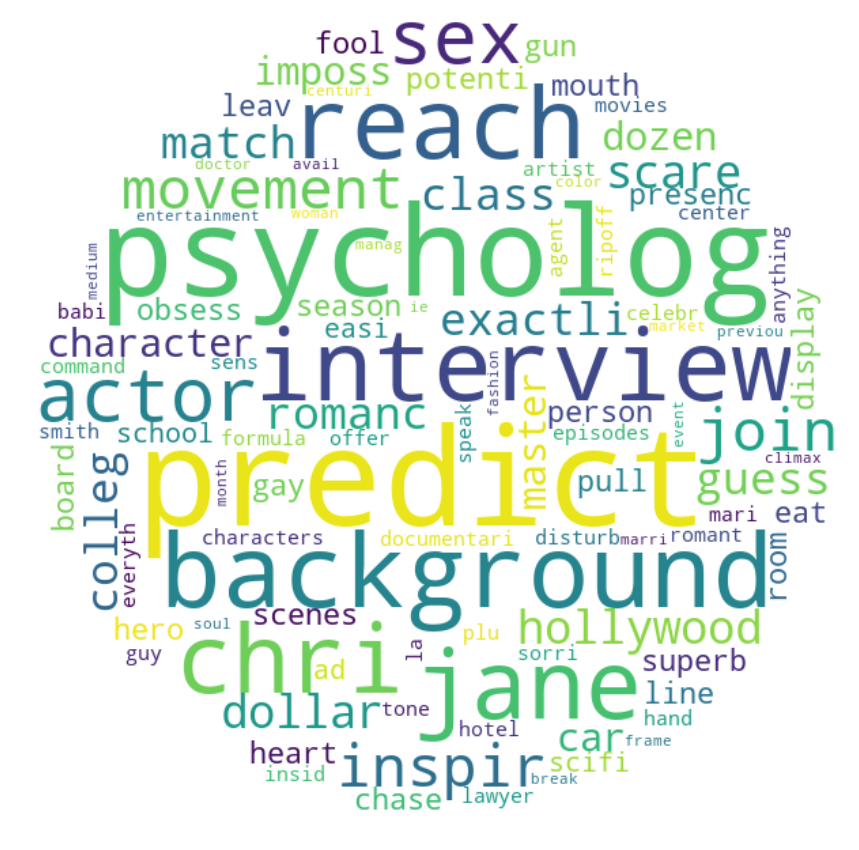

<Figure size 1080x1080 with 0 Axes>

In [32]:
mask_array = np.array(Image.open('/Users/lyndon/knime-workspace/wordcloud/circle.png'))
wc = WordCloud(background_color='white', 
               mask=mask_array, 
               stopwords = [],
               max_font_size = 100)
wc.generate_from_frequencies(dict(corpus))
plt.imshow(wc, interpolation="bilinear")
plt.axis('off')
plt.figure()
wc.to_file('/Users/lyndon/knime-workspace/wordcloud/wordcloud.png')